In [1]:
import sys
import pathlib
import os
import platform
import copy
sys.path.append('../..')

import matplotlib.pyplot as plt
import psutil
import autograd.numpy as np

from lib.graph import Graph
from lib.functions import InputOutput
from lib.functions import parse_command_line_args
from simulator.fiber.assets.propagator import Propagator

from simulator.fiber.evaluator_subclasses.evaluator_rfawg import RadioFrequencyWaveformGeneration
from simulator.fiber.evaluator_subclasses.evaluator_pulserep import PulseRepetition

from simulator.fiber.evolver import HessianProbabilityEvolver, OperatorBasedProbEvolver

from simulator.fiber.node_types_subclasses.inputs import PulsedLaser
from simulator.fiber.node_types_subclasses.outputs import Photodiode,MeasurementDevice

from simulator.fiber.node_types_subclasses.multi_path import VariablePowerSplitter,FrequencySplitter,DualOutputMZM
from simulator.fiber.node_types_subclasses.single_path import IntensityModulator, WaveShaper,OpticalAmplifier,PhaseModulator
from simulator.fiber.node_types_subclasses.terminals import TerminalSource, TerminalSink

from algorithms.parameter_optimization import parameters_optimize
from algorithms.topology_optimization import topology_optimization, save_hof, plot_hof



In [2]:

# 调用参数解析函数
# options_cl = parse_command_line_args(sys.argv[1:])
# 确保路径加载正确
sys.path.append("E:/aesop-master/mytest")
# 初始化 IO 类
io = InputOutput(directory="results", verbose=True)
# 初始化保存路径
io.init_save_dir(sub_path="test_run", unique_id=True)

# 保存机器元数据
io.save_machine_metadata(sub_path="metadata")




Saving machine metadata to E:\Documents\asope_data\results\20250704_1C99_test_run\metadata\metadata.json


<AxesSubplot:>

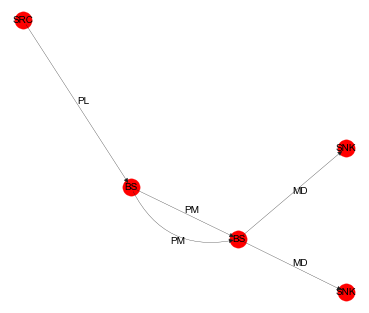

In [20]:

# 遗传算法参数设置
ga_opts = {'n_generations': 1,
           'n_population': 40,
           'n_hof': 25,
           'verbose': False,
           'num_cpus': psutil.cpu_count()-1}
# 光脉冲传播模拟器初始化
propagator = Propagator(window_t=4e-9, n_samples=2**15, central_wl=1.55e-6)
pulse_width, rep_t, peak_power = (3e-12, 1/10.0e9, 1.0)
p, q = (1, 2)   # 目标重复频率为输入的 (p/q) 倍
input_laser = PulsedLaser(parameters_from_name={'pulse_width': pulse_width, 'peak_power': peak_power,
                                                't_rep': rep_t, 'pulse_shape': 'gaussian',
                                                'central_wl': 1.55e-6, 'train': True})
input_laser.node_lock = True
input_laser.protected = True
input = input_laser.get_pulse_train(propagator.t, pulse_width=pulse_width, rep_t=rep_t, peak_power=peak_power)  # 光脉冲输入信号
target = input_laser.get_pulse_train(propagator.t, pulse_width=pulse_width * (p / q), rep_t=rep_t * (p / q), peak_power=peak_power * (p / q))   #目标脉冲 2倍
evaluator = PulseRepetition(propagator, target, pulse_width=pulse_width, rep_t=rep_t, peak_power=peak_power)


evolver = HessianProbabilityEvolver(verbose=False)
# evolver = OperatorBasedProbEvolver(verbose=False)

# 初始拓扑构建
md = MeasurementDevice()
md.protected = True
nodes = {'source': TerminalSource(),
             0: VariablePowerSplitter(),
             1: VariablePowerSplitter(),
             'sink1': TerminalSink(node_name='sink1'),
             'sink2': TerminalSink(node_name='sink2')
             }
edges = {('source', 0): input_laser,
         (0, 1, 1): PhaseModulator(),
         (0, 1, 2): PhaseModulator(),
         (1, 'sink1'): md,
         (1, 'sink2'): md,
         }

graph = Graph.init_graph(nodes, edges)
graph.update_graph()
graph.initialize_func_grad_hess(propagator, evaluator, exclude_locked=True)

graph.draw()

In [ ]:
update_rule = 'tournament'
hof, log = topology_optimization(copy.deepcopy(graph), propagator, evaluator, evolver, io,
                                 ga_opts=ga_opts, local_mode=False, update_rule=update_rule,
                                 parameter_opt_method='ADAM+GA',
                                 include_dashboard=False, crossover_maker=None,
                                 ged_threshold_value=0.8)

save_hof(hof, io)   #保存精英个体
plot_hof(hof, propagator, evaluator, io)

2025-03-14 18:10:08,375	INFO resource_spec.py:231 -- Starting Ray with 1.12 GiB memory available for workers and up to 0.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


NameError: name 'log' is not defined

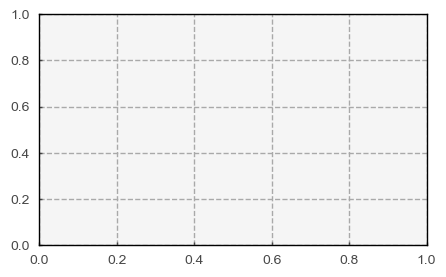

In [33]:
fig, ax = plt.subplots(1, 1, figsize=[5, 3])
ax.fill_between(log['generation'], log['best'], log['mean'], color='grey', alpha=0.2)
ax.plot(log['generation'], log['best'], label='Best')
ax.plot(log['generation'], log['mean'], label='Population mean')
ax.plot(log['generation'], log['minimum'], color='darkgrey', label='Population minimum')
ax.plot(log['generation'], log['maximum'], color='black', label='Population maximum')
ax.set(xlabel='Generation', ylabel='Cost')
ax.legend()

io.save_fig(fig, 'topology_log.png')    #损失函数迭代变化曲线